# Perakendede Müşteri Segmentasyonu

Müşteri segmentasyonu müşterileri benzer davranış/alışkanlıklara sahip segmentlere bölmeyi hedefler. Aynı segmenteki müşterilerin benzer tercihlere sahip olması beklendiğinden pazarlama ve CRM stratejilerinin belirlenmesi için kullanılabilir. 

Segmentasyon çalışmaları davranışsal ya da coğrafi/demografik özniteliklerle gerçekletirilebilir. 

Müşterilerin kaç farklı örüntüye sahip olduğu bilinmediğinden güdümsüz öğrenme kullanılır. Bu çalışmada da Kümeleme yöntemiyle bir segmentasyon gerçekleştireceğiz. 


# Segmentasyon

Perakendede ürünlerin kategorilendirilmesi sıklıkla görülen bir durumdur. Bir moda perakendecisi için aşağıdaki gibi bir ürün sınıflandırması (taxonomy) örnek olarak gösterilebilir.

    - Erkek giyim
        - Pantolon
        - Şort
        - Gömlek
            - Casual
            - Business
        - Ayakkabı
    - Kadın giyim
    - ...
    
FMCG alanı için de aşağıdaki gibi bir örnek verebiliriz:
    - Meyve/sebze
        - Meyve
        - Sebze
        - Organik ürünler
    - Deterjan/Temizlik ürünleri
        - Çamaşır
        - Bulaşık
        - Duş jelleri
        - Ev temizliği
    - Kırmızı et
    - ...
    
## Amaç

Müşterilerin alışveriş yaptıkları ürünlere göre bir kümeleme çalışması gerekleştireceğiz. Elde edeceğimiz segmentlerin aşağıdakilere benzemesini umuyoruz:

* Meyve ve kırmızı et alan müşteriler
* Genelde deterjan alan müşteriler ...
    
## Veri

Müşterilerin 6 kategoride yaptıkları alışverişleri içeren bir veri seti üzerinden segmentasyon çalışmasını gerçekleştireceğiz. RFM (Recency, Frequency, Monetary / Yakınlık, Sıklık, Mali değer) üzerinden yapılmış bir çalışma ve bu çalışmanın yapıldığı veri setini linkte bulabilirsiniz (Chen et al. in "Data Mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining"):

https://archive.ics.uci.edu/ml/datasets/Online+Retail


Öncelikle kullanacağımız paketleri ve veri setini yükleyelim. 

In [1]:
print(__doc__)
%matplotlib inline
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
import pandas as pd 
from sklearn.metrics import roc_auc_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
sns.set_style("whitegrid")



Automatically created module for IPython interactive environment


C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Veri seti 'Transactions_2015.csv' adlı bir dosyada. Veri setini pandas aracılığıyla okuyarak bir dataframe'e aktaralım.'

In [2]:
df_train = pd.read_csv('Transactions_2015.csv')

print(df_train.head())
print(df_train.describe())

   Customer_ID  Category_1  Category_2  Category_3  Category_4  Category_5  \
0      1007727      165.97      180.84      145.85       20.20       16.52   
1      1013989      129.20      189.21       98.14        1.05        1.39   
2      1014544      126.41      153.14         NaN       74.03      106.53   
3      1022560      150.60      259.20       96.72       28.28       21.34   
4      1026878      215.30       70.25      368.51       44.02       39.03   

   Category_6  
0         NaN  
1        0.24  
2         NaN  
3         NaN  
4         NaN  
        Customer_ID    Category_1    Category_2    Category_3    Category_4  \
count  2.500000e+04  24840.000000  24397.000000  20006.000000  24192.000000   
mean   5.035996e+07    201.542572    273.615216    206.641346     44.794671   
std    2.857235e+07    206.348262    649.180535    262.600508     58.728076   
min    1.007727e+06     41.930000     22.310000   -213.380000      0.010000   
25%    2.554748e+07    139.840000     66

Veri setinde eksik değerlerin (NaN) olduğunu görüyoruz. Bu bir alışveriş verisi olduğu için bu müşterilerin o kategoriden alışveriş yapmadıkları anlamına gelmektedir. **fillna** (pandas) fonksiyonunu kullanarak bunları 0 ile değiştirelim.

In [3]:
df_train.fillna(0,inplace = True)

print(df_train.head())
print(df_train.describe())

   Customer_ID  Category_1  Category_2  Category_3  Category_4  Category_5  \
0      1007727      165.97      180.84      145.85       20.20       16.52   
1      1013989      129.20      189.21       98.14        1.05        1.39   
2      1014544      126.41      153.14        0.00       74.03      106.53   
3      1022560      150.60      259.20       96.72       28.28       21.34   
4      1026878      215.30       70.25      368.51       44.02       39.03   

   Category_6  
0        0.00  
1        0.24  
2        0.00  
3        0.00  
4        0.00  
        Customer_ID    Category_1    Category_2    Category_3    Category_4  \
count  2.500000e+04  25000.000000  25000.000000  25000.000000  25000.000000   
mean   5.035996e+07    200.252700    267.015617    165.362671     43.346907   
std    2.857235e+07    206.313828    642.675817    249.016958     58.311832   
min    1.007727e+06      0.000000      0.000000   -213.380000      0.000000   
25%    2.554748e+07    139.057500     63

Veri setine tekrar baktığımızda kimi müşterilerin belirli kategorilerde 10000 TL üzeri harcama yaptığını, kimi müşterilerin ise eksi harcamaya sahip olduğunu görüyoruz. Eksi değerler iadeleri gösterebilir. Öncelikle dataframede kaç eksi değer olduğuna bakalım.

In [4]:
negative_cells = df_train<0
print(negative_cells.sum())

Customer_ID    0
Category_1     0
Category_2     0
Category_3     8
Category_4     0
Category_5     0
Category_6     2
dtype: int64


Gözlem sayısı az olduğu için bu müşterileri analizden çıkarmayı tercih edebiliriz. Normalde böyle bir durumun keşfedilmesi durumunda veriyi yeniden hazırlamak gibi çözümlere gitmek gerekebilir.

In [5]:
df_train = df_train[negative_cells.sum(axis=1) < 1]
print(np.shape(df_train))

(24990, 7)


Müşterilerin alışveriş toplamlarını bulup aykırı gözlemlerin var olup olmadığına bakalım. Bunun için **boxplot** fonksiyonunu kullanabiliriz.

0    529.38
1    419.23
2    460.11
3    556.14
4    737.11
dtype: float64
count    24990.000000
mean       739.844055
std        992.083641
min         25.030000
25%        350.267500
50%        563.540000
75%        773.285000
max      29165.580000
dtype: float64


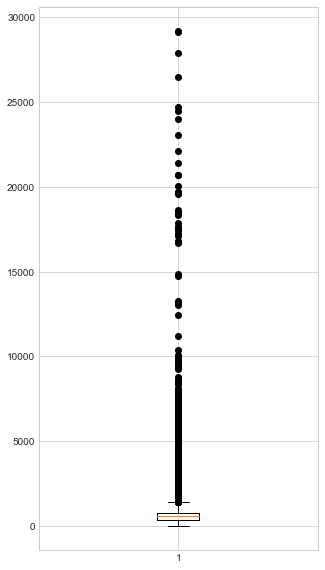

In [6]:
df_sum = df_train[['Category_' + str(i) for i in [1,2,3,4,5,6]]].sum(axis=1)
print(df_sum.head())

print(df_sum.describe())
# basic plot


plt.figure(figsize=(5,10))
plt.boxplot(x=df_sum.values, sym='ko')
plt.show()

20000 TL'den çok harcama yapan çok az müşteri var. Kimi kritik değerleri bastırarak veri setinin dağılımı hakkında daha iyi bir fikre sahip olabiliriz. Genelde çok yüksek harcamaya sahip olan müşteriler için özel programlar, CRM temsilcileri de kullanılabilir. Bu nedenle bu müşterileri analize dahil etmek gerekli olmayabilir.

In [7]:
print(df_sum.min())
print(np.percentile(df_sum, 1))
print(np.percentile(df_sum, 5))
print(np.percentile(df_sum, 10))
print(np.percentile(df_sum, 25))
print(np.percentile(df_sum, 50))
print(np.percentile(df_sum, 75))
print(np.percentile(df_sum, 90))
print(np.percentile(df_sum, 95))
print(np.percentile(df_sum, 99))
print(df_sum.max())


25.03
191.0256
231.7345
253.369
350.2675
563.54
773.285
1509.196
1958.8995
2732.7317
29165.58


En yüksek harcamayı yapan müşteri 29000 TL'den fazla bir harcama yapmışken, müşterilerin %99'u 2730 TL'den daha düşük bir harcama yapmış. Bu değeri kullanarak müşterilerin en değerli %1'lik kısmını veri setinden çıkaralım.

        Customer_ID    Category_1    Category_2    Category_3    Category_4  \
count  2.474000e+04  24740.000000  24740.000000  24740.000000  24740.000000   
mean   5.035127e+07    185.061174    238.808747    150.784874     40.060982   
std    2.857101e+07     95.982992    377.869486    134.756991     34.824503   
min    1.007727e+06      0.000000      0.000000      0.000000      0.000000   
25%    2.552414e+07    138.657500     63.510000     26.617500     10.050000   
50%    5.038503e+07    168.670000    102.615000    138.830000     29.470000   
75%    7.497713e+07    205.755000    180.620000    245.750000     65.770000   
max    9.999723e+07   1891.280000   2096.040000    645.020000    178.850000   

        Category_5    Category_6           sum  
count  24740.00000  24740.000000  24740.000000  
mean      40.14716     18.624725    673.487662  
std       35.08454     34.575839    479.860914  
min        0.00000      0.000000     25.030000  
25%       10.05000      0.000000    346.622

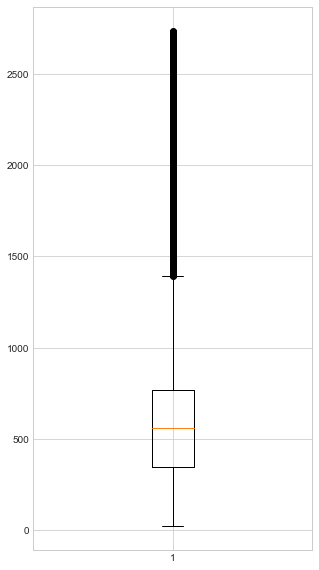

In [8]:
df_train['sum'] = df_sum

df_train = df_train[df_train['sum'] <= np.percentile(df_train['sum'], 99)]
df_train = df_train[df_train['sum'] >0]

print(df_train.describe())
plt.figure(figsize=(5,10))
plt.boxplot(df_train['sum'].values, sym='ko')
plt.show()

Aykırı değerlere sahip müşterileri eledikten sonra analize başlayabiliriz. Öncelikle müşterilerin 6 kategorideki harcamalarının bir korelasyon haritasını çıkaralım.

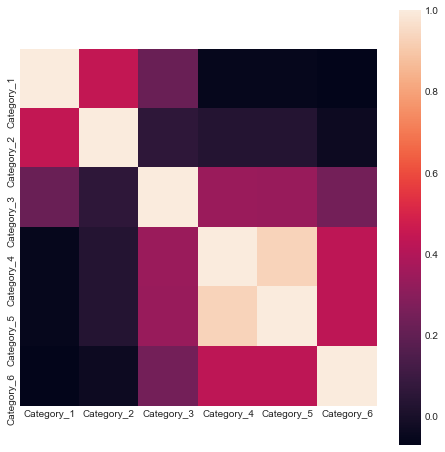

In [9]:
col_cat = [ u'Category_1', u'Category_2', u'Category_3', u'Category_4', u'Category_5', u'Category_6']
#col_mon = [ u'last_amo_6', u'last_amo_5', u'last_amo_4', u'last_amo_3', u'last_amo_2', u'last_amo_1']

df_train_cat = df_train[col_cat]
#df_train_mon = df_train[col_mon]

correlation_matrix = df_train_cat.corr()

plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix,square=True)
plt.show()

Artık ürün kategorilerini öğrenme zamanı

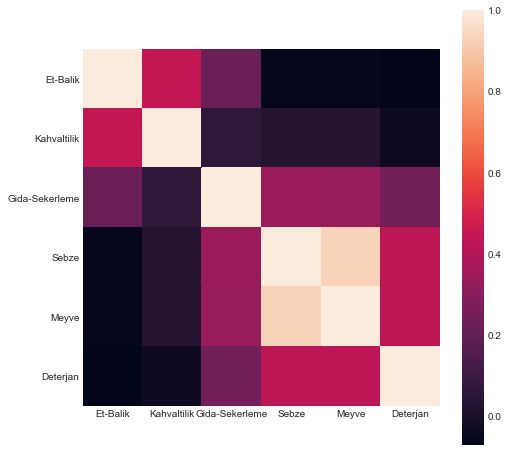

In [10]:
df_train_cat.columns = ['Et-Balik', 'Kahvaltilik', 'Gida-Sekerleme', 'Sebze', 'Meyve', 'Deterjan']

correlation_matrix = df_train_cat.corr()

plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix,square=True)
plt.show()

Ürün kategorilerine bakarak 'Meyve' ve 'Sebze'yi 'Meyve-Sebze adlı bir kolonda toplayalım.

C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


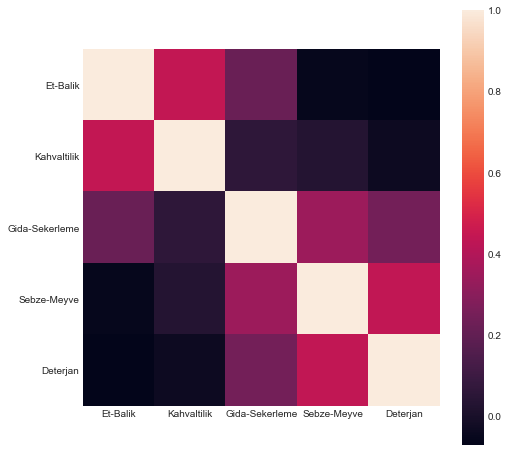

In [11]:
df_train_cat['Sebze-Meyve'] = df_train_cat['Sebze'] + df_train_cat['Meyve']

df_train_cat.drop(['Sebze', 'Meyve'], axis=1, inplace=True)
df_train_cat = df_train_cat[['Et-Balik', 'Kahvaltilik', 'Gida-Sekerleme','Sebze-Meyve',  'Deterjan']]

correlation_matrix = df_train_cat.corr()

plt.figure(figsize=(8,8))
sns.heatmap(correlation_matrix,square=True)
plt.show()

## Kümeleme 

KMeans modülünü kullanma zamanımız geldi. Segment sayısını bilmediğimiz için 5 küme ile bir deneme yapabiliriz. Daha sonra sonuçları değerlendireceğiz. 


In [12]:
kmeans = KMeans(n_clusters = 5, n_init=10, random_state=0)
kmeans.fit(df_train_cat)

df_centers = pd.DataFrame(kmeans.cluster_centers_)
df_centers.columns = df_train_cat.columns

print(df_centers)

     Et-Balik  Kahvaltilik  Gida-Sekerleme  Sebze-Meyve   Deterjan
0  164.032797   113.294131       38.323959    37.977312   5.603671
1  338.040060  1454.567627      188.394030    93.384112  16.647933
2  129.882902   102.015231      201.791654   164.934707  46.289465
3  263.207420  1062.910504      149.413634    75.188495  12.184629
4  232.903399   100.562231      351.588003    80.322884  20.088991


Küme merkezlerini görselleştirelim. bunun için paralel plot kullanacağız.

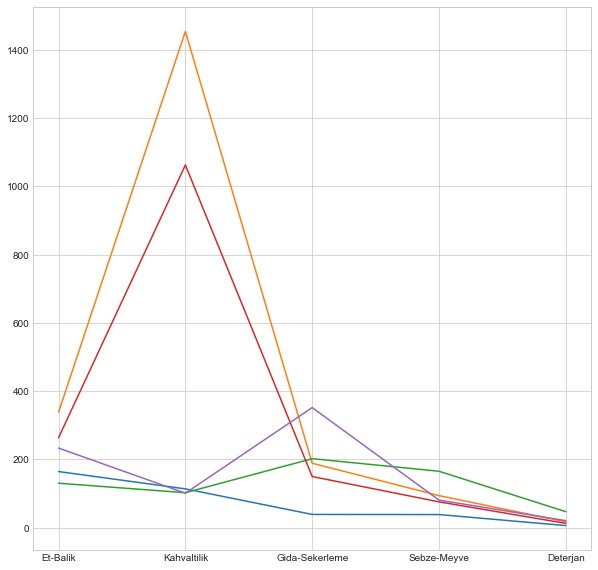

In [13]:
plt.figure(figsize=(10,10))
plt.plot(df_centers.transpose().values)
plt.xticks(np.arange(5), df_train_cat.columns)
plt.show()

Oluşturduğumuz kümeler farklı harcamalara sahip müşterileri göstermesine rağmen istediğimiz segment bilgisine ulaşamadık. Farklı miktarlarda da olsa benzer örüntülere sahip müşterileri görmek için müşterilerin kategori bazında alışveriş yüzdelerini inceleyelim.

   Et-Balik  Kahvaltilik  Gida-Sekerleme  Sebze-Meyve  Deterjan
0  0.290827     0.128515        0.448797     0.106785  0.025077
1  0.338818     0.446849        0.147688     0.054771  0.011874
2  0.160194     0.701125        0.084471     0.046537  0.007673
3  0.635277     0.194597        0.081734     0.076415  0.011977
4  0.207220     0.172906        0.248776     0.304200  0.066897


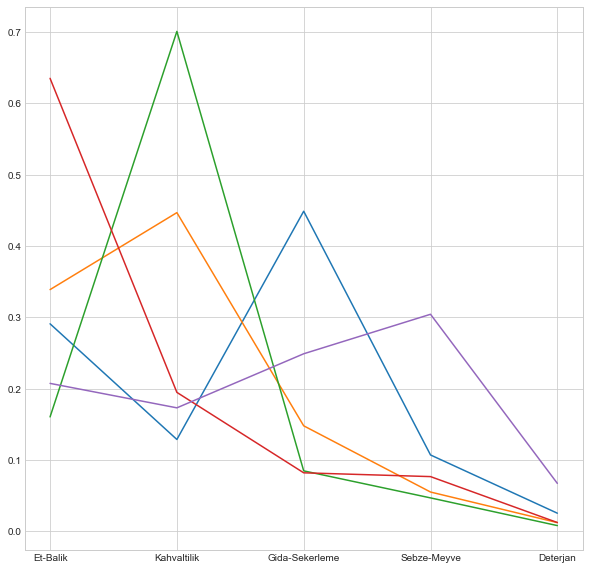

[0 1 2 3 4]
[5747 3872 2995 6436 5690]


In [14]:
df_train_cat_pct = df_train_cat.div(df_train_cat.sum(axis=1), axis=0)

kmeans = KMeans(n_clusters=5, n_init = 10, random_state=0)

kmeans.fit(df_train_cat_pct)
df_centers = pd.DataFrame(kmeans.cluster_centers_)
df_centers.columns = df_train_cat_pct.columns

print(df_centers)

plt.figure(figsize=(10,10))
plt.plot(df_centers.transpose().values)
plt.xticks(np.arange(5), df_train_cat.columns)
plt.show()


a,b = np.unique(kmeans.labels_, return_counts=True)

print(a)
print(b)


Segmentler daha anlamlı duruyorlar. Şimdi görsel olarak da test edelim.

# Parallel Plot

Segmentleri parallel plotlarla görselleştirelim. Bu yöntemde her müşteri bir çizgi ile temsil ediliyor ve harcama yüzdeleri çiziliyor. 0 ve 1 numaralı kümeler için bu çalışmayı yapalım. Önce harcama miktarları sonra da yüzdeleri kullanalım.

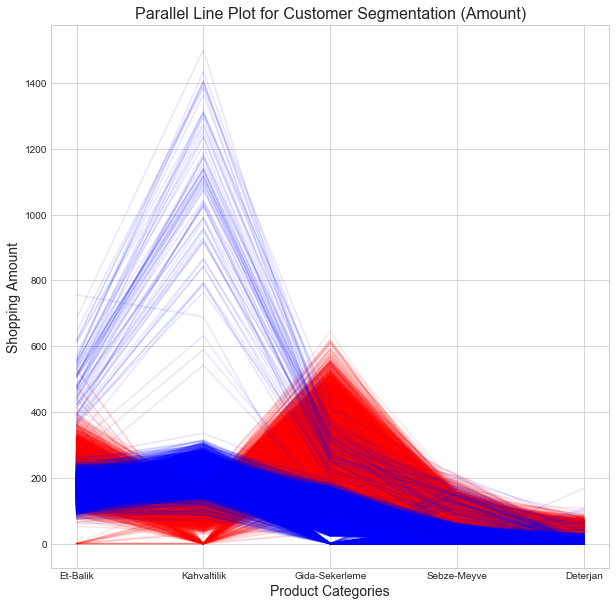

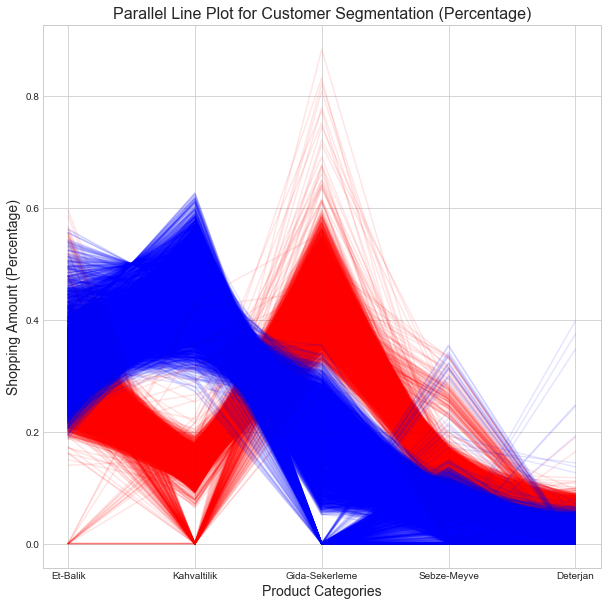

In [15]:
x_ticks = df_train_cat.columns

ncols = 5 


df0 = df_train_cat[kmeans.labels_ == 0]
df1 = df_train_cat[kmeans.labels_ == 1]
fig = plt.figure(figsize=(10, 10))
df0 = np.asarray(df0.transpose())
df1 = np.asarray(df1.transpose())

plt.plot(df0, color="red", alpha=0.1)
plt.plot(df1, color="blue", alpha=0.1)
x_range = range(0, ncols)
plt.xlabel("Product Categories", fontsize = 14)
plt.ylabel("Shopping Amount", fontsize = 14)

plt.xticks(x_range, x_ticks)
plt.title('Parallel Line Plot for Customer Segmentation (Amount)', fontsize=16)
plt.show()


df0 = df_train_cat_pct[kmeans.labels_ == 0]
df1 = df_train_cat_pct[kmeans.labels_ == 1]
fig = plt.figure(figsize=(10, 10))
df0 = np.asarray(df0.transpose())
df1 = np.asarray(df1.transpose())

plt.plot(df0, color="red", alpha=0.1)
plt.plot(df1, color="blue", alpha=0.1)
x_range = range(0, ncols)
plt.xlabel("Product Categories", fontsize = 14)
plt.ylabel("Shopping Amount (Percentage)", fontsize = 14)

plt.xticks(x_range, x_ticks)
plt.title('Parallel Line Plot for Customer Segmentation (Percentage)', fontsize=16)
plt.show()
 

Aynı grafiği bütün küme çiftleri için çizelim

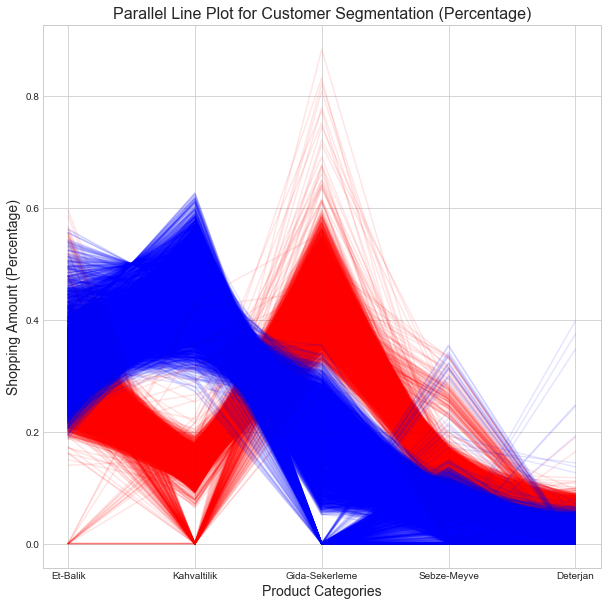

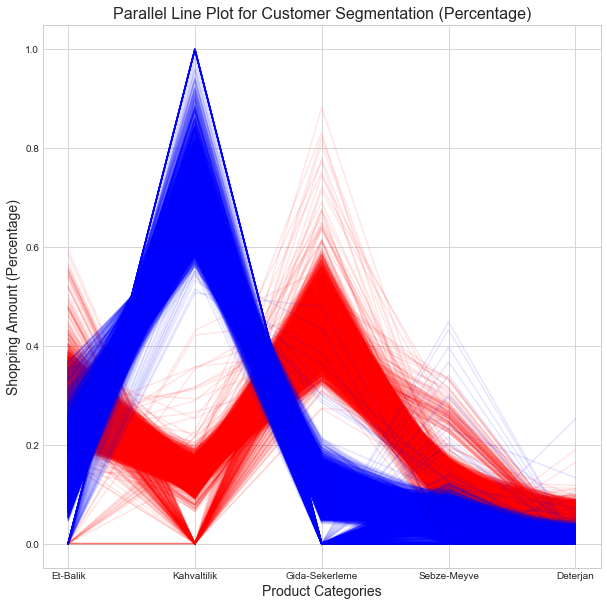

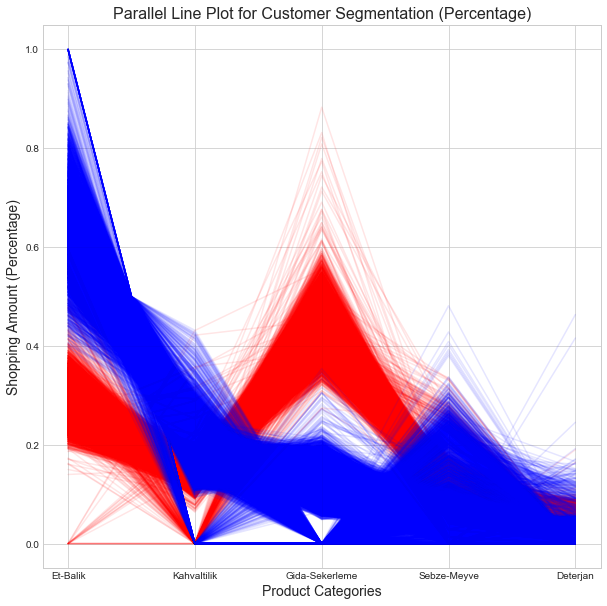

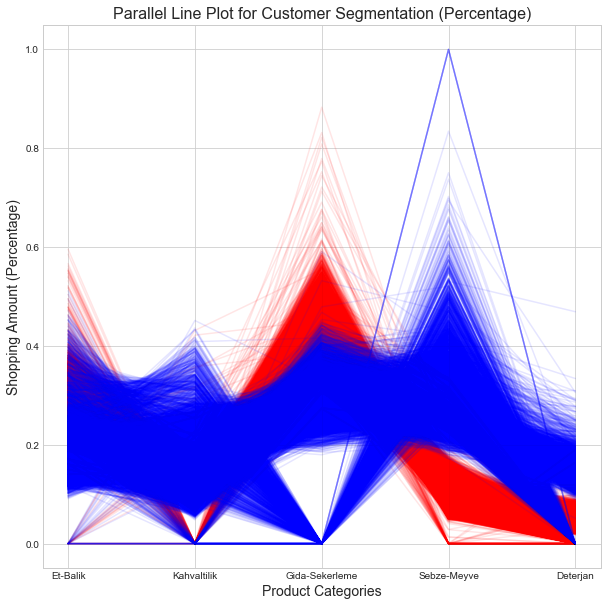

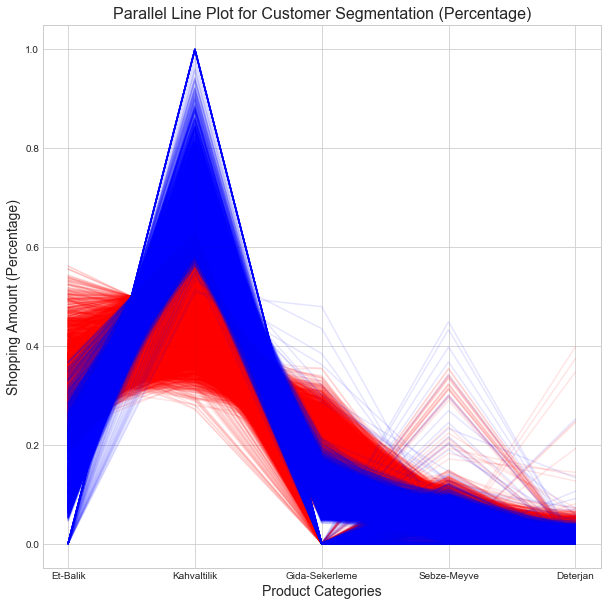

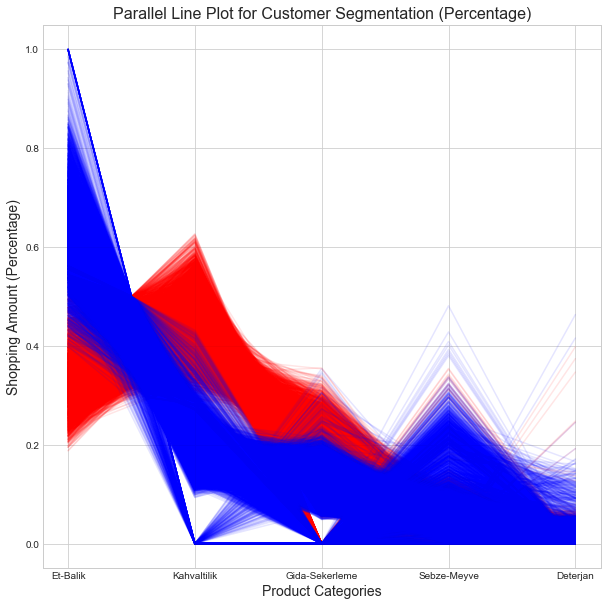

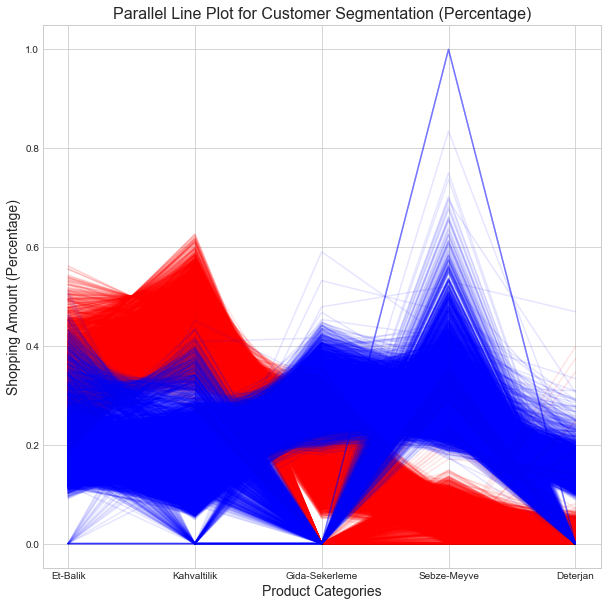

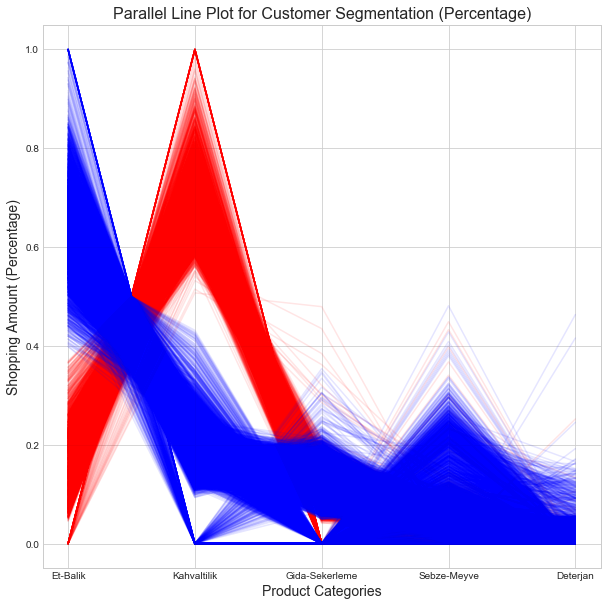

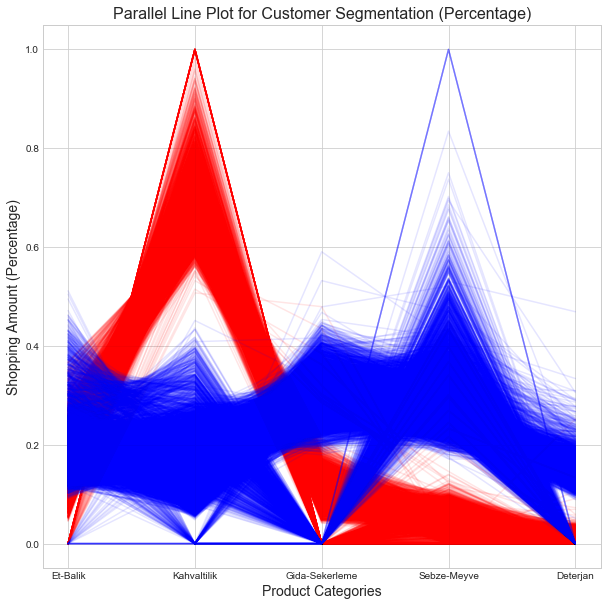

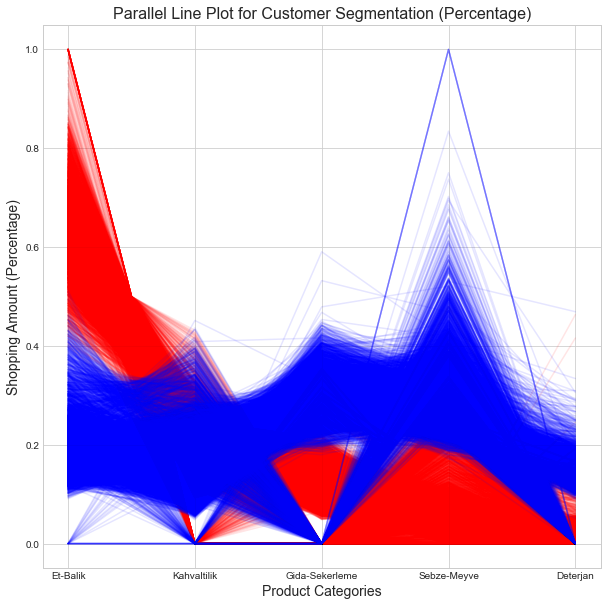

In [16]:

for i in range(5):
    for j in range(i+1,5):
        df0 = df_train_cat_pct[kmeans.labels_ == i]
        df1 = df_train_cat_pct[kmeans.labels_ == j]
        fig = plt.figure(figsize=(10, 10))
        df0 = np.asarray(df0.transpose())
        df1 = np.asarray(df1.transpose())

        plt.plot(df0, color="red", alpha=0.1)
        plt.plot(df1, color="blue", alpha=0.1)
        x_range = range(0, ncols)
        plt.xlabel("Product Categories", fontsize = 14)
        plt.ylabel("Shopping Amount (Percentage)", fontsize = 14)

        plt.xticks(x_range, x_ticks)
        plt.title('Parallel Line Plot for Customer Segmentation (Percentage)', fontsize=16)
        plt.show()

Kümeleme çalışması sonucunda birbirinden ayrışan kümeler elde etmeyi başardık.

# References

Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197-208, 2012.

## Silhouette scores (Optional)

Silhuet skoru aynı ve farklı kümelerin uzaklığına bakarak her gözlem için bir skor velirler. 

Küme içi ortalama uzaklık (a) ve en yakın diğer kümeye olan ortalama uzaklık (b) kulanılarak (b - a) / max(a, b) formülü ile hesaplanır. 

Aşağıdaki koşullardan biri sağlanırsa küme sayısını değiştirerek analizi tekrar etmek denenebilir:
* Ortalama skorun altında olan bir küme varsa
* Küme boyutları arasında çok büyük farklar varsa
* Negatif skoru olan çok fazla gözlem varsa.


For n_clusters = 3 The average silhouette_score is : 0.524672336156


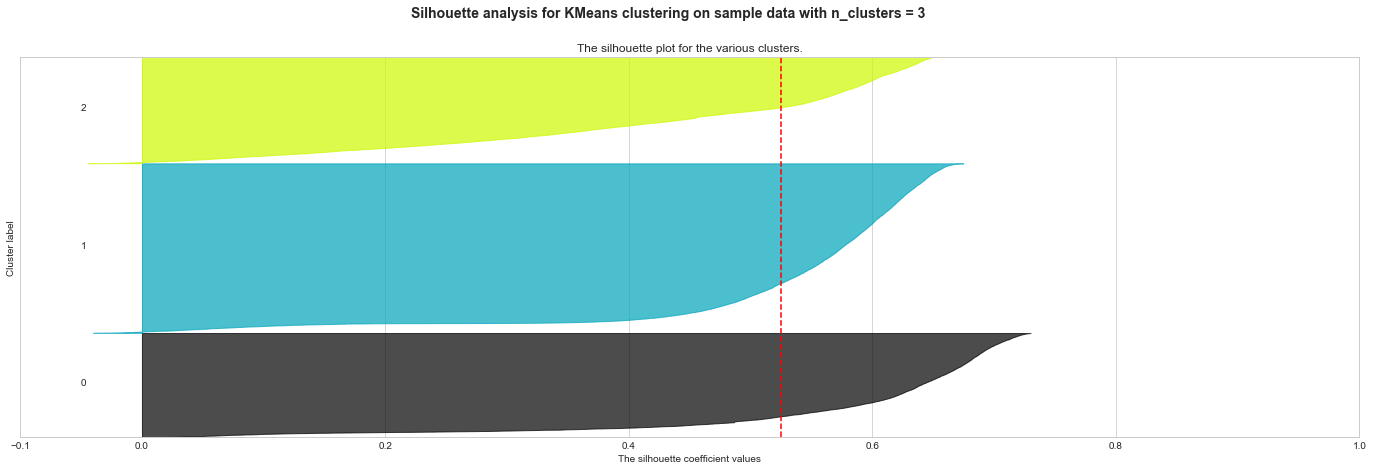

For n_clusters = 4 The average silhouette_score is : 0.494642155903


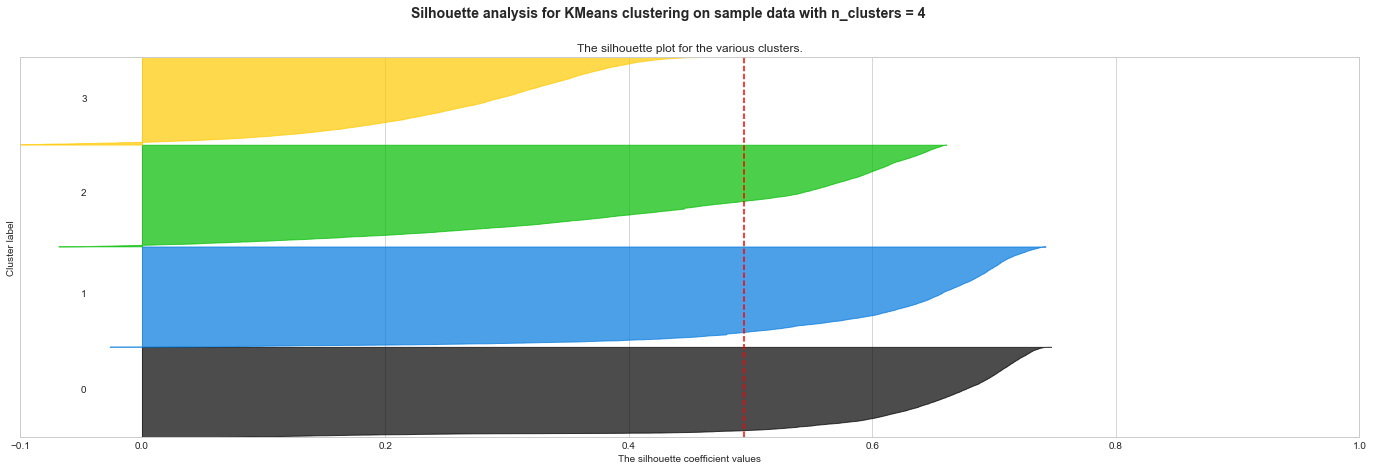

For n_clusters = 5 The average silhouette_score is : 0.482936843549


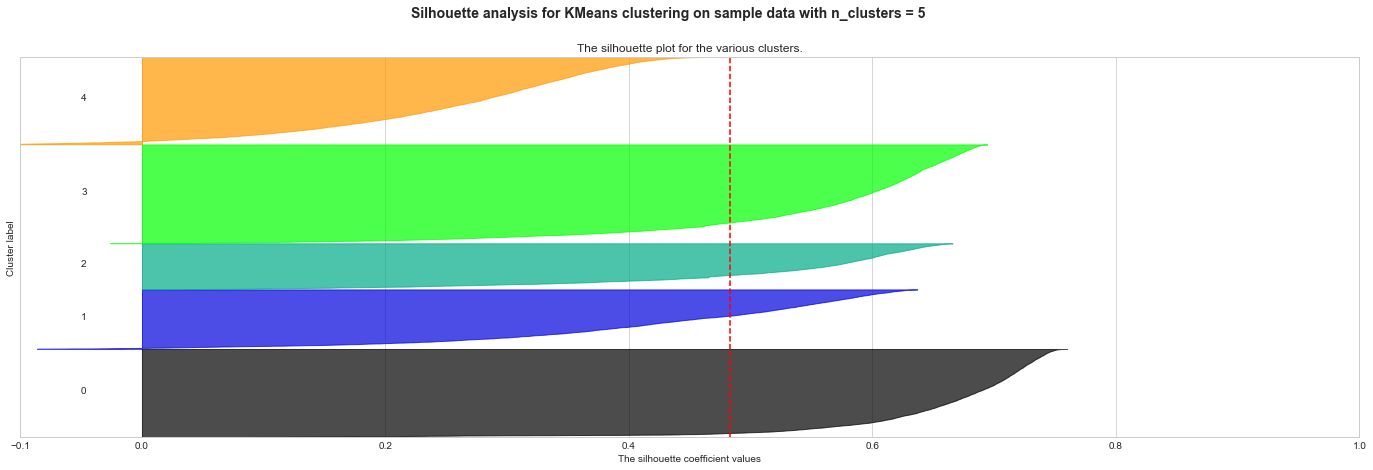

In [17]:

range_n_clusters = [3,4,5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(24, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_train_cat_pct) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    cluster_labels = clusterer.fit_predict(df_train_cat_pct)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_train_cat_pct, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_train_cat_pct, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

 
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    